In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import torch
from sklearn.metrics import roc_auc_score,confusion_matrix,plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import torch
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
from transformers import pipeline
from scipy.special import softmax
import shap
from datasets import load_dataset
# Just get 1000 data points and only the text columns

/home/gwan/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-10-27 21:24:22.287452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-27 21:24:22.702471: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-27 21:24:22.853253: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable t

In [12]:
from sklearn.metrics import precision_recall_fscore_support

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
torch.version.cuda

'11.7'

In [3]:
sentences = train.text.values
sentences_test = test.text.values
y_test = test['annotation']

## Transfomer based contextual embedding

In [4]:
tokenizer = AutoTokenizer.from_pretrained("TimKond/S-BioLinkBert-MedQuAD")

model = SentenceTransformer('TimKond/S-BioLinkBert-MedQuAD')

In [5]:
# Apprerantly Very simple embeddings clustering based on BERT does not tell anything about the sentiment
embeddings = model.encode(sentences)


In [6]:

embeddings_test = model.encode(sentences_test)

## 1: Machine learning based on embeddings

In [23]:
rf = RandomForestClassifier(class_weight={0:1,1:100},max_features=100,max_depth = 100)

rf.fit(X = embeddings,y = train['annotation'])

RandomForestClassifier(class_weight={0: 1, 1: 100}, max_depth=100,
                       max_features=100)

In [24]:
rf_pred = rf.predict(embeddings_test)
rf_pred_prob = rf.predict_proba(embeddings_test)

In [29]:
from sklearn.metrics import accuracy_score


accuracy_score(y_test, rf_pred)

0.8691588785046729

In [25]:
precision_recall_fscore_support(y_test, rf_pred, average='binary')

(0.6, 0.2, 0.3, None)

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


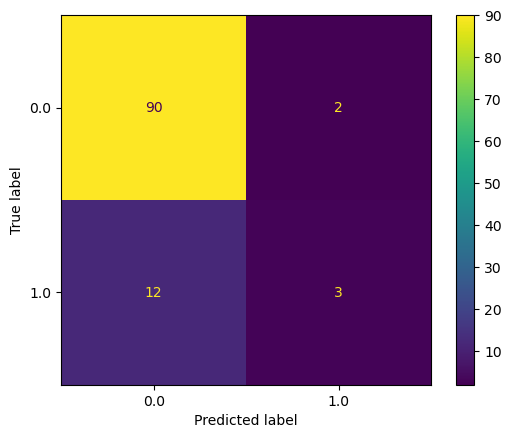

In [28]:
plot_confusion_matrix(rf,embeddings_test,y_test)

# 2: Pretrained Subjective BERT

In [30]:
classify = pipeline(
    task="text-classification",
    model="cffl/bert-base-styleclassification-subjective-neutral",
    return_all_scores=True,tokenizer="cffl/bert-base-styleclassification-subjective-neutral", max_length=512, truncation=True,
)

In [31]:
result_pretrained = classify(sentences_test.tolist())

In [34]:
bert1_pred_prob = np.zeros(test.shape[0])
for i,x in enumerate(result_pretrained):
    bert1_pred_prob[i] = x[1]['score']

In [42]:
accuracy_score(y_test,np.where(bert1_pred_prob > 0.5, 1, 0))

0.6635514018691588

In [43]:
precision_recall_fscore_support(y_test,np.where(bert1_pred_prob > 0.5, 1, 0), average='binary')

(0.1111111111111111, 0.2, 0.14285714285714285, None)

# 3: Fine Tuned Model

In [2]:
data_files = {"train": "train.csv", "test": "test.csv"}
dataset = load_dataset(path = './',data_files=data_files)

Using custom data configuration .-b273d4a8c1ca6129
Found cached dataset csv (/home/gwan/.cache/huggingface/datasets/csv/.-b273d4a8c1ca6129/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)
100%|██████████| 2/2 [00:00<00:00, 258.53it/s]


In [3]:
task='sentiment'
MODEL = "cffl/bert-base-styleclassification-subjective-neutral"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
# tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [4]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="pt")

In [5]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)


Loading cached processed dataset at /home/gwan/.cache/huggingface/datasets/csv/.-b273d4a8c1ca6129/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-40ebd37e8d67e4df.arrow
100%|██████████| 1/1 [00:00<00:00, 13.03ba/s]


In [6]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)

Loading cached shuffled indices for dataset at /home/gwan/.cache/huggingface/datasets/csv/.-b273d4a8c1ca6129/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-9646d2f7f5b6d64e.arrow


In [7]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2)

In [8]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [9]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

In [11]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch",
weight_decay= 0.01,warmup_steps = 50, num_train_epochs=10)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: annotation, id, text.
***** Running training *****
  Num examples = 425
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 540
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: wan19990901. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.606149,0.841121,0.105263,0.250000,0.066667
2,No log,0.436950,0.859813,0.000000,0.000000,0.000000
3,No log,0.409029,0.859813,0.000000,0.000000,0.000000
4,No log,0.477334,0.859813,0.000000,0.000000,0.000000
5,No log,0.352198,0.859813,0.000000,0.000000,0.000000
6,No log,0.365378,0.850467,0.428571,0.461538,0.400000
7,No log,0.495112,0.831776,0.526316,0.434783,0.666667
8,No log,0.542071,0.850467,0.428571,0.461538,0.400000
9,No log,0.663559,0.822430,0.457143,0.400000,0.533333
10,0.330700,0.651014,0.850467,0.428571,0.461538,0.400000


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: annotation, id, text.
***** Running Evaluation *****
  Num examples = 107
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: annotation, id, text.
***** Running Evaluation *****
  Num examples = 107
  Batch size = 8
Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: annotation, id, text.
***** Running Evaluation *****
  Num examples = 107
  Batch size = 8
Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior

TrainOutput(global_step=540, training_loss=0.3172623934569182, metrics={'train_runtime': 252.8155, 'train_samples_per_second': 16.811, 'train_steps_per_second': 2.136, 'total_flos': 1118221985280000.0, 'train_loss': 0.3172623934569182, 'epoch': 10.0})